# Notebook Desciption

This notebook performs the behavior analyses, which includes:
  a) Behavior feature plot;
  b) Correlation analysis;
  c) Behavior pattern evaluation using summary measures (mean and SD, median and IQR);
  d) Correlation matrix of the percentage of time spent.
  (part (e) Univariate analysis of baseline characteristics (demographics) is included in another notebook).

In [1]:
import pandas as pd
from matplotlib.pylab import plt
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import seaborn as sns
import sklearn
from sklearn.ensemble import IsolationForest
import scipy.stats as stats

In [2]:
data_nopop = pd.read_csv("gs://hpn_cte_advanced_stats_data_repository/yahui_data_repository/Aging 202312/AGING_DATA_EXTRACT__NEW_NQSD_20231214.csv")
population = pd.read_csv("gs://hpn_cte_advanced_stats_data_repository/yahui_data_repository/Aging 202312/population_updates_20231214.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (640,642,646,653) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data =  pd.merge(data_nopop, population, on=['PET_ID'], how='left')

In [4]:
data['study_food'].unique()

array(['Peach', 'None', 'Black'], dtype=object)

In [5]:
qualified = data[data['IS_QUALIFIED_NEW']=='YES']
pd.options.mode.chained_assignment = None  # Disable the warning
#transform Stuck Accel missing values to 0
for column in qualified.columns:
    if 'TD_8' in column:
        qualified.loc[:, column] = qualified.loc[:, column].fillna(0)


In [6]:
final = qualified.drop(columns=[col for col in qualified.columns if '46' in col])

In [7]:
activity_map = {
    'VAR_TD_1_Q5_2': 'resting',
    'VAR_TD_3_Q5_2': 'running',
    'VAR_TD_5_Q5_2': 'scratching',
    'VAR_TD_4_Q5_2': 'shaking',
    'VAR_TD_12_Q5_2': 'sleeping',
    'VAR_TD_2_Q5_2': 'walking',
    'VAR_IDX_11_Q5_2': 'Sleep Quality',
    'VAR1_TD_8_Q5_2': 'Stuck AccelX',
    'VAR2_TD_8_Q5_2': 'Stuck AccelY',
    'VAR3_TD_8_Q5_2': 'Stuck AccelZ',
    'VAR4_TD_8_Q5_2': 'Stuck AccelM'
}



# Behavior Feature Plot

In [8]:
day = 'NORMALIZED_QUALIFYING_STUDY_DAY_NEW'
# Create a new column 'period' 
final['period'] = 'Other'

# Set 'period' based on the conditions for final
final.loc[final[day] < 0, 'period'] = 'Baseline'
final.loc[final[day] >= 0, 'period'] = 'Treatment'

In [9]:
baseline = final[final['period'] == 'Baseline']

In [10]:
def rename_columns(df):
    """ 

    The function 'rename_columns' is used for rename the feature columns into meaningful activity columns.

    Parameters
    ----------
    df : str
        The dataframe which contains the feature columns.
  
    """ 
    replace_dict_activity = {

        '_12': 'Sleeping',
        '_1': 'Resting',
        '_3': 'Running',
        '_5': 'Scratching',
        '_4': 'Shaking',
        '_2': 'Walking'
    }

    replace_dict_time = {
        'Q1': '12am_6am',
        'Q2': '6am_12pm',
        'Q3': '12pm_6pm',
        'Q4': '6pm_12am',
        'Q5': 'All_day'
    }

    # New column names
    new_cols = []

    for col in df.columns:
        # Initialize activity
        activity = ''

        # If the column doesn't start with 'VAR' or 'DER', add it to new_cols without conversion
        if not col.startswith('VAR') and not col.startswith('DER'):
            new_cols.append(col)
            continue

        # Remove the _1 at last
        if col.endswith('_2'):
            col = col[:-2]

        # Replace activity codes with names
        for old, new in replace_dict_activity.items():
            if old in col:
                col = col.replace(old, '')
                activity = new
                break

        # Remove 'VAR' or 'DER'
        if col.startswith('VAR'):
            col = col[3:]
        elif col.startswith('DER'):
            col = col[3:]

        # Replace time codes with names
        for old, new in replace_dict_time.items():
            if old in col:
                col = col.replace(old, new)
                break

        # Place the replaced part (activity) at the beginning
        col = activity + col

        new_cols.append(col)

    df.columns = new_cols
    
    return df

In [11]:
baseline = baseline[baseline['study_food'] != 'None']

In [12]:
baseline['trt'] = baseline['study_food'].apply(lambda x: 1 if x == 'Black' else 0)

In [13]:
baseline.head()

,PET_ID,EXTERNAL_ID,DEVICE_ID,STUDY_ID,STUDY_NAME,PET_NAME,DATE,NORMALIZED_STUDY_DAY,NORMALIZED_QUALIFYING_STUDY_DAY,STUDY_DAY_COUNTER,STUDY_GROUP,BASELINE_START,START_DATE,ENROLLMENT_DATE,COMPLETION_DATE,END_DATE,EXCESSIVE_RUNNING,TIMEZONE,QUALIFYING_DATA_DAY,IS_QUALIFIED,DAILYDATAQUALITYINDREASON,VAR_TD_1_Q1_2,VAR_CE_1_Q1_2,VAR_MIN_1_Q1_2,VAR_MED_1_Q1_2,VAR_RANG_1_Q1_2,VAR_MAX_1_Q1_2,VAR_AVG_1_Q1_2,VAR_SD_1_Q1_2,VAR_IQR_1_Q1_2,VAR_ACE_1_Q1_2,VAR_SDCE_1_Q1_2,VAR_IQRCE_1_Q1_2,VAR_CE3SD_1_Q1_2,VAR_TD_3_Q1_2,VAR_CE_3_Q1_2,VAR_MIN_3_Q1_2,VAR_MED_3_Q1_2,VAR_RANG_3_Q1_2,VAR_MAX_3_Q1_2,VAR_AVG_3_Q1_2,VAR_SD_3_Q1_2,VAR_IQR_3_Q1_2,VAR_ACE_3_Q1_2,VAR_SDCE_3_Q1_2,VAR_IQRCE_3_Q1_2,VAR_CE3SD_3_Q1_2,VAR_TD_5_Q1_2,VAR_CE_5_Q1_2,VAR_MIN_5_Q1_2,VAR_MED_5_Q1_2,VAR_RANG_5_Q1_2,VAR_MAX_5_Q1_2,VAR_AVG_5_Q1_2,VAR_SD_5_Q1_2,VAR_IQR_5_Q1_2,VAR_ACE_5_Q1_2,VAR_SDCE_5_Q1_2,VAR_IQRCE_5_Q1_2,VAR_CE3SD_5_Q1_2,VAR_TD_4_Q1_2,VAR_CE_4_Q1_2,VAR_MIN_4_Q1_2,VAR_MED_4_Q1_2,VAR_RANG_4_Q1_2,VAR_MAX_4_Q1_2,VAR_AVG_4_Q1_2,VAR_SD_4_Q1_2,VAR_IQR_4_Q1_2,VAR_ACE_4_Q1_2,VAR_SDCE_4_Q1_2,VAR_IQRCE_4_Q1_2,VAR_CE3SD_4_Q1_2,VAR_TD_12_Q1_2,VAR_CE_12_Q1_2,VAR_MIN_12_Q1_2,VAR_MED_12_Q1_2,VAR_RANG_12_Q1_2,VAR_MAX_12_Q1_2,VAR_AVG_12_Q1_2,VAR_SD_12_Q1_2,VAR_IQR_12_Q1_2,VAR_ACE_12_Q1_2,VAR_SDCE_12_Q1_2,VAR_IQRCE_12_Q1_2,VAR_CE3SD_12_Q1_2,VAR_TD_2_Q1_2,VAR_CE_2_Q1_2,VAR_MIN_2_Q1_2,VAR_MED_2_Q1_2,VAR_RANG_2_Q1_2,VAR_MAX_2_Q1_2,VAR_AVG_2_Q1_2,VAR_SD_2_Q1_2,VAR_IQR_2_Q1_2,VAR_ACE_2_Q1_2,VAR_SDCE_2_Q1_2,VAR_IQRCE_2_Q1_2,VAR_CE3SD_2_Q1_2,VAR_TD_45_Q1_2,VAR_CE_45_Q1_2,VAR_MIN_45_Q1_2,VAR_MED_45_Q1_2,VAR_RANG_45_Q1_2,VAR_MAX_45_Q1_2,VAR_AVG_45_Q1_2,VAR_SD_45_Q1_2,VAR_IQR_45_Q1_2,VAR_ACE_45_Q1_2,VAR_SDCE_45_Q1_2,VAR_IQRCE_45_Q1_2,VAR_IDX_11_Q1_2,VAR_CE3SD_45_Q1_2,VAR_TD_1_Q2_2,VAR_CE_1_Q2_2,VAR_MIN_1_Q2_2,VAR_MED_1_Q2_2,VAR_RANG_1_Q2_2,VAR_MAX_1_Q2_2,VAR_AVG_1_Q2_2,VAR_SD_1_Q2_2,VAR_IQR_1_Q2_2,VAR_ACE_1_Q2_2,VAR_SDCE_1_Q2_2,VAR_IQRCE_1_Q2_2,VAR_CE3SD_1_Q2_2,VAR_TD_3_Q2_2,VAR_CE_3_Q2_2,VAR_MIN_3_Q2_2,VAR_MED_3_Q2_2,VAR_RANG_3_Q2_2,VAR_MAX_3_Q2_2,VAR_AVG_3_Q2_2,VAR_SD_3_Q2_2,VAR_IQR_3_Q2_2,VAR_ACE_3_Q2_2,VAR_SDCE_3_Q2_2,VAR_IQRCE_3_Q2_2,VAR_CE3SD_3_Q2_2,VAR_TD_5_Q2_2,VAR_CE_5_Q2_2,VAR_MIN_5_Q2_2,VAR_MED_5_Q2_2,VAR_RANG_5_Q2_2,VAR_MAX_5_Q2_2,VAR_AVG_5_Q2_2,VAR_SD_5_Q2_2,VAR_IQR_5_Q2_2,VAR_ACE_5_Q2_2,VAR_SDCE_5_Q2_2,VAR_IQRCE_5_Q2_2,VAR_CE3SD_5_Q2_2,VAR_TD_4_Q2_2,VAR_CE_4_Q2_2,VAR_MIN_4_Q2_2,VAR_MED_4_Q2_2,VAR_RANG_4_Q2_2,VAR_MAX_4_Q2_2,VAR_AVG_4_Q2_2,VAR_SD_4_Q2_2,VAR_IQR_4_Q2_2,VAR_ACE_4_Q2_2,VAR_SDCE_4_Q2_2,VAR_IQRCE_4_Q2_2,VAR_CE3SD_4_Q2_2,VAR_TD_12_Q2_2,VAR_CE_12_Q2_2,VAR_MIN_12_Q2_2,VAR_MED_12_Q2_2,VAR_RANG_12_Q2_2,VAR_MAX_12_Q2_2,VAR_AVG_12_Q2_2,VAR_SD_12_Q2_2,VAR_IQR_12_Q2_2,VAR_ACE_12_Q2_2,VAR_SDCE_12_Q2_2,VAR_IQRCE_12_Q2_2,VAR_CE3SD_12_Q2_2,VAR_TD_2_Q2_2,VAR_CE_2_Q2_2,VAR_MIN_2_Q2_2,VAR_MED_2_Q2_2,VAR_RANG_2_Q2_2,VAR_MAX_2_Q2_2,VAR_AVG_2_Q2_2,VAR_SD_2_Q2_2,VAR_IQR_2_Q2_2,VAR_ACE_2_Q2_2,VAR_SDCE_2_Q2_2,VAR_IQRCE_2_Q2_2,VAR_CE3SD_2_Q2_2,VAR_TD_45_Q2_2,VAR_CE_45_Q2_2,VAR_MIN_45_Q2_2,VAR_MED_45_Q2_2,VAR_RANG_45_Q2_2,VAR_MAX_45_Q2_2,VAR_AVG_45_Q2_2,VAR_SD_45_Q2_2,VAR_IQR_45_Q2_2,VAR_ACE_45_Q2_2,VAR_SDCE_45_Q2_2,VAR_IQRCE_45_Q2_2,VAR_IDX_11_Q2_2,VAR_CE3SD_45_Q2_2,VAR_TD_1_Q3_2,VAR_CE_1_Q3_2,VAR_MIN_1_Q3_2,VAR_MED_1_Q3_2,VAR_RANG_1_Q3_2,VAR_MAX_1_Q3_2,VAR_AVG_1_Q3_2,VAR_SD_1_Q3_2,VAR_IQR_1_Q3_2,VAR_ACE_1_Q3_2,VAR_SDCE_1_Q3_2,VAR_IQRCE_1_Q3_2,VAR_CE3SD_1_Q3_2,VAR_TD_3_Q3_2,VAR_CE_3_Q3_2,VAR_MIN_3_Q3_2,VAR_MED_3_Q3_2,VAR_RANG_3_Q3_2,VAR_MAX_3_Q3_2,VAR_AVG_3_Q3_2,VAR_SD_3_Q3_2,VAR_IQR_3_Q3_2,VAR_ACE_3_Q3_2,VAR_SDCE_3_Q3_2,VAR_IQRCE_3_Q3_2,VAR_CE3SD_3_Q3_2,VAR_TD_5_Q3_2,VAR_CE_5_Q3_2,VAR_MIN_5_Q3_2,VAR_MED_5_Q3_2,VAR_RANG_5_Q3_2,VAR_MAX_5_Q3_2,VAR_AVG_5_Q3_2,VAR_SD_5_Q3_2,VAR_IQR_5_Q3_2,VAR_ACE_5_Q3_2,VAR_SDCE_5_Q3_2,VAR_IQRCE_5_Q3_2,VAR_CE3SD_5_Q3_2,VAR_TD_4_Q3_2,VAR_CE_4_Q3_2,VAR_MIN_4_Q3_2,VAR_MED_4_Q3_2,VAR_RANG_4_Q3_2,VAR_MAX_4_Q3_2,...,VAR_MIN_45_Q4_2,VAR_MED_45_Q4_2,VAR_RANG_45_Q4_2,VAR_MAX_45_Q4_2,VAR_AVG_45_Q4_2,VAR_SD_45_Q4_2,VAR_IQR_45_Q4_2,VAR_ACE_45_Q4_2,VAR_SDCE_45_Q4_2,VAR_IQRCE_45

In [14]:
df1 = baseline.select_dtypes(include='number').copy()

# Keep 'aging_flag' column and feature columns based on specified criteria
columns_to_keep = ['trt'] + [
    col for col in df1.columns 
    if col.startswith('VAR_') and 'RANG' not in col and col.endswith('_2')
]

keywords = ['walking', 'running', 'active']
numbers = ['60', '300', '900']
columns_with_both_criteria = [
    col for col in df1.columns 
    if any(kw in col for kw in keywords) and any(num in col for num in numbers)
]

# Combine and de-duplicate the lists, then filter out columns with '_11_'
final_columns = list(set(columns_to_keep + columns_with_both_criteria))
final_columns = [col for col in final_columns if '_11_' not in col and '_45_' not in col and '_46_' not in col or col == 'aging_flag']
# Update df1 to keep only the final columns
df1 = df1[final_columns]


In [15]:
df1 = rename_columns(df1)

In [16]:
feature_columns = [col for col in df1.columns if col != 'trt']

In [17]:
def behavior_plot_abs_all(df, feature_columns, binary_var, title, fontsize, legend_title):
    """ 

    The function 'behavior_plot_abs' uses the same way as in the 'behavior_plot_new', except for the sorting order on the y-axis. 
    Here it's sorted by the absolute value of groups' difference.

    Parameters
    ----------
    df : str
        The name of dataset to input
    feature_columns : list
        The list of feature columns
    binary_var : str
        The group variables, for example, the aging flag that denotes aging vs. non-aging
    title : str
        The title for the output figure
    fontsize : int
        The fontsize for the y-axis
    legend_title: str
        The legend title
  
       """      
    category_colors = {
        'Running': 'green',
        'Walking': 'lime',
        'Shaking': 'limegreen',
        'Scratching': 'yellowgreen',
        'Resting': 'orange',
        'Sleeping': 'red',
        'running': 'green',
        'walking': 'lime',
        'active': 'red'
    }
    
    # Calculate the overall mean and standard deviation
    overall_mean = df[feature_columns].mean()
    standard_deviation = df[feature_columns].std()

    # Calculate the mean for each feature where binary_var = 0
    mean_group_0 = df[df[binary_var] == 0][feature_columns].mean()

    # Calculate the mean for each feature where binary_var = 1
    mean_group_1 = df[df[binary_var] == 1][feature_columns].mean()

    # Calculate the difference of the means for groups from the means for all patients divided by the standard deviation
    difference_group_0 = (mean_group_0 - overall_mean) / standard_deviation
    difference_group_1 = (mean_group_1 - overall_mean) / standard_deviation

    # Calculate the differences between the two groups for each feature
    differences = abs(difference_group_1 - difference_group_0)

    # Calculate the confidence intervals for each group
    n_group_0 = len(df[df[binary_var] == 0])
    ci_group_0 = stats.t.interval(0.95, n_group_0 - 1, loc=mean_group_0, scale=standard_deviation / np.sqrt(n_group_0))
    n_group_1 = len(df[df[binary_var] == 1])
    ci_group_1 = stats.t.interval(0.95, n_group_1 - 1, loc=mean_group_1, scale=standard_deviation / np.sqrt(n_group_1))

    # Calculate the differences between the two groups for each feature's confidence interval
    ci_difference_group_0 = (ci_group_0[1] - ci_group_0[0]) / (2 * standard_deviation)
    ci_difference_group_1 = (ci_group_1[1] - ci_group_1[0]) / (2 * standard_deviation)


    # Get the indices for sorting the differences in ascending order
    sorted_indices = np.argsort(differences)[::-1]
    
    # Limit to top 100 features
    top_100_indices = sorted_indices[:100]
    
    # Select the top 100 features based on the sorted differences
    top_100_features = [feature_columns[i] for i in top_100_indices]
    
    # Convert feature_columns to a NumPy array
    feature_columns_np = np.array(top_100_features)

    # Sort the differences and ci based on the sorted_indices
    sorted_difference_group_0 = difference_group_0.loc[top_100_features]
    sorted_difference_group_1 = difference_group_1.loc[top_100_features]
    ci_difference_group_0_top_100 = np.array([ci_difference_group_0[i] for i in top_100_indices])
    ci_difference_group_1_top_100 = np.array([ci_difference_group_1[i] for i in top_100_indices])

    non_labels = 'Peach'
    labels = legend_title

    # Create the scatter plot
    fig1, ax = plt.subplots(figsize=(10, 6))

    y = np.arange(len(top_100_features))[::-1]

    # Plot the sorted_difference_group_0 values
    ax.scatter(sorted_difference_group_0, y, c='salmon', label=non_labels, s=10)

    # Plot the sorted_difference_group_1 values
    ax.scatter(sorted_difference_group_1, y, c='cyan', label=labels, s=10)

    # Plot the confidence intervals for group 0
    ax.errorbar(sorted_difference_group_0, y, xerr=ci_difference_group_0_top_100, fmt='none', ecolor='salmon', elinewidth=0.5, capsize=0, alpha=0.5)

    # Plot the confidence intervals for group 1
    ax.errorbar(sorted_difference_group_1, y, xerr=ci_difference_group_1_top_100, fmt='none', ecolor='cyan', elinewidth=0.5, capsize=0, alpha=0.5)

    # Set the y-axis labels to be the sorted feature names
    ax.set_yticks(y)
    ax.set_yticklabels(top_100_features, fontsize=fontsize)

    # Set the y-axis label colors based on the first string
    y_labels = [label.split('_')[0] for label in top_100_features]

    # Change the color of the y-axis labels
    for label, ticklabel in zip(y_labels, ax.get_yticklabels()):
        ticklabel.set_color(category_colors[label])

    # Set the x-axis label
    ax.set_xlabel('Difference of Means (Standard Deviations)')
    ax.set_title(title)
    # Set the x-axis limits as the minimum and maxixmum values
    min_val = min(sorted_difference_group_0.min(), sorted_difference_group_1.min())
    max_val = max(sorted_difference_group_0.max(), sorted_difference_group_1.max())
    xticks = np.arange(min_val, max_val, 0.125)  # Set the interval to 0.1
    plt.xticks(xticks, rotation=90)

    # Add a grey grid as the background
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

    
    # Add a legend to the side of the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()

    fig1.savefig('behavior_feature_plot_left.pdf', bbox_inches='tight')
    return top_100_features[:20]

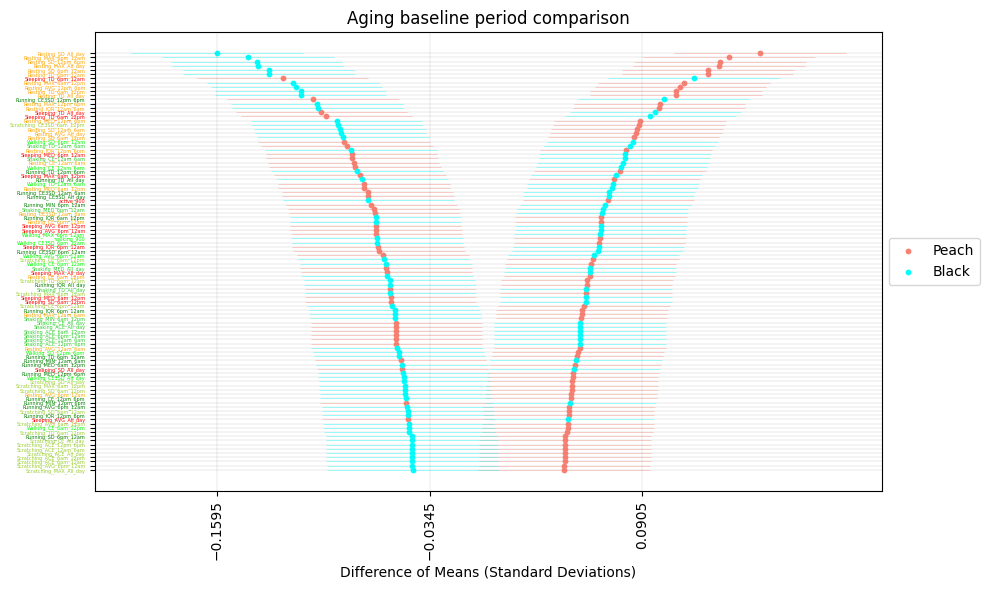

In [18]:
# The behavior feature plot with all features
top_features = behavior_plot_abs_all(df1, feature_columns, 'trt', 'Aging baseline period comparison', fontsize=3.5, legend_title='Black')

In [19]:
top_features

['Resting_SD_All_day',
 'Resting_MAX_6pm_12am',
 'Resting_SD_12pm_6pm',
 'Resting_MAX_All_day',
 'Resting_SD_6pm_12am',
 'Resting_TD_6pm_12am',
 'Sleeping_TD_6pm_12am',
 'Resting_MAX_6am_12pm',
 'Resting_AVG_12pm_6pm',
 'Resting_TD_6am_12pm',
 'Resting_TD_All_day',
 'Running_CE3SD_12pm_6pm',
 'Resting_MAX_12pm_6pm',
 'Resting_IQR_12am_6am',
 'Sleeping_TD_All_day',
 'Sleeping_TD_6am_12pm',
 'Resting_MED_12pm_6pm',
 'Scratching_CE3SD_6am_12pm',
 'Resting_SD_12am_6am',
 'Resting_AVG_All_day']

# Correlation Analysis

In [20]:
def rename_columns(col_name):
    """ 

    The function 'rename_columns' is used for rename the feature columns into meaningful activity columns.

    Parameters
    ----------
    col_name : str
        The name of the column need to be transferred.
  
       """  
    activity_dict = {
        '12': 'Sleeping',
        '11': 'SleepQuality',
        '1': 'Resting',
        '3': 'Running',
        '5': 'Scratching',
        '4': 'Shaking',
        '2': 'Walking'
    }

    time_dict = {
        'Q1': '12am_6am',
        'Q2': '6am_12pm',
        'Q3': '12pm_6pm',
        'Q4': '6pm_12am',
        'Q5': 'AllDay'
    }

    # Step 1 and 2
    terms = col_name.split('_')

    # Step 3
    terms[2] = activity_dict.get(terms[2], terms[2])

    # Step 4
    terms[3] = time_dict.get(terms[3], terms[3])

    # Replace terms[0] with terms[2]
    terms[0] = terms[2]
    
    # Remove terms[2]
    terms.pop(2)

    # Remove the last term
    terms = terms[:-1]

    # Join the remaining terms
    return '_'.join(terms)

In [21]:
#Georgia tech behaviors
correlation_data = final.loc[:, final.columns.str.startswith('VAR') &
                                  final.columns.str.endswith('_2') &
                                  ~(final.columns.str.split('_').str[0] != 'VAR') &
                                  ~final.columns.str.contains('45')]

In [22]:
#correlation_data = correlation_data.loc[:, correlation_data.columns.str.contains('Q5')]

In [23]:
correlation_data.columns = [rename_columns(col) for col in correlation_data.columns]

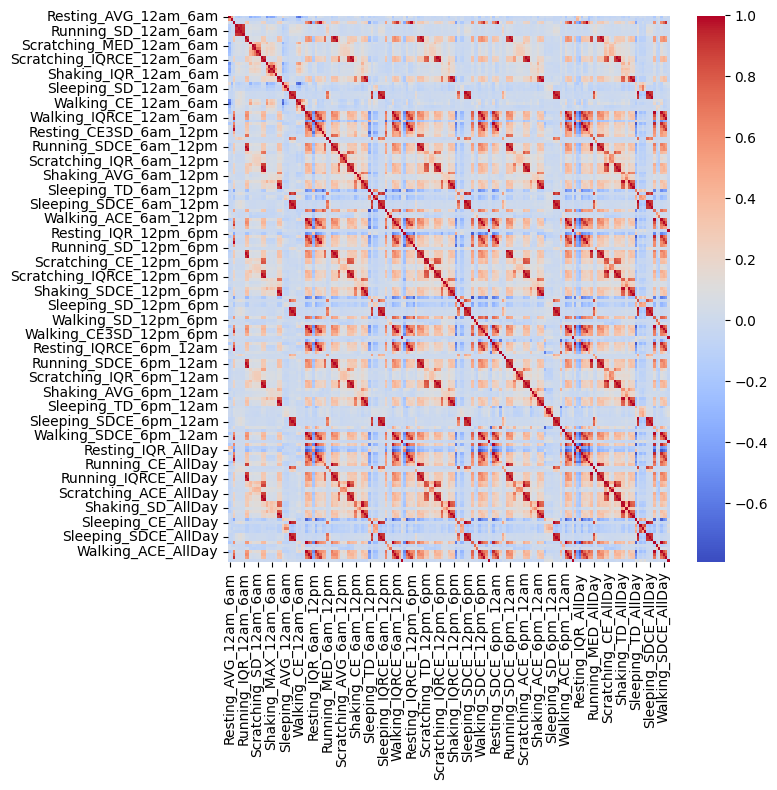

In [24]:
# Calculate the correlation matrix
correlation_matrix = correlation_data.corr().abs()
# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Create a new correlation matrix with just the highly correlated features
highly_correlated_df = correlation_data[to_drop]
new_corr_matrix = highly_correlated_df.corr()

plt.figure(figsize=(8, 8))

sns.heatmap(new_corr_matrix, cmap='coolwarm')
plt.tight_layout()
plt.savefig('heatmap.pdf')

# Missing values

In [25]:
activity_map2 = {
    'VAR_TD_1_Q5_2': 'Resting (All Day)',
    'VAR_TD_3_Q5_2': 'Running (All Day)',
    'VAR_TD_5_Q5_2': 'Scratching (All Day)',
    'VAR_TD_4_Q5_2': 'Shaking (All Day)',
    'VAR_TD_12_Q5_2': 'Sleeping (All Day)',
    'VAR_TD_2_Q5_2': 'Walking (All Day)',
    'VAR_IDX_11_Q5_2': 'Sleep Quality',
    'VAR1_TD_8_Q5_2': 'Stuck AccelX',
    'VAR2_TD_8_Q5_2': 'Stuck AccelY',
    'VAR3_TD_8_Q5_2': 'Stuck AccelZ',
    'VAR4_TD_8_Q5_2': 'Stuck AccelM'

}

missing_data = data[list(activity_map2.keys())]

# Calculate the percentage of missing data
missing_data_percentage = (missing_data.isnull().sum() / len(missing_data)) * 100

renamed_data_percentage = missing_data_percentage.rename(index=activity_map2).round(2)

# Create a DataFrame from the renamed series
df = pd.DataFrame(renamed_data_percentage)
df.set_axis(['Percentage of Missing Data'], axis=1, inplace=True)
display(df)

,Percentage of Missing Data
Resting (All Day),0.00
Running (All Day),0.00
Scratching (All Day),0.00
Shaking (All Day),0.00
Sleeping (All Day),0.00
Walking (All Day),0.00
Sleep Quality,1.83
Stuck AccelX,89.13
Stuck AccelY,89.13
Stuck AccelZ,89.13


# Number of Baseline Days

In [26]:
filtered_df = data[data['wearables_itt'] == True]

filtered_df['DATE'].count()

13951

In [27]:
filtered_df = data[data['wearables_pp'] == True]

filtered_df['DATE'].count()

5594

In [28]:
itt_qualified = data[(data['wearables_itt'] == True) & (data['IS_QUALIFIED_NEW'] == 'YES')]['DATE'].count()
100*itt_qualified/data[data['wearables_itt'] == True]['DATE'].count()

77.65751559028027

In [29]:
itt_qualified

10834

In [30]:
pp_qualified = data[(data['wearables_pp'] == True) & (data['IS_QUALIFIED_NEW'] == 'YES')]['DATE'].count()
100*pp_qualified/data[data['wearables_pp'] == True]['DATE'].count()

85.5917053986414

In [31]:
pp_qualified

4788

# Behavior pattern evaluation using summary measures (mean and SD, median and IQR)

In [32]:
def perform_tests(data1, data2, value_column):
    non_values = data1[value_column]
    values = data2[value_column]

    # Perform Mann-Whitney U test
    U_stat, p_value_mannwhitneyu = stats.mannwhitneyu(non_values, values, alternative='two-sided')
    print('U-Statistic (Mann-Whitney U test):', U_stat)
    print('P-Value (Mann-Whitney U test):', p_value_mannwhitneyu)

    # Perform permutation test
    observed_difference = np.mean(non_values) - np.mean(values)
    num_permutations = 1000
    permuted_differences = []
    np.random.seed(0)  # Set a random seed for reproducibility

    for _ in range(num_permutations):
        # Randomly permute the values
        permuted_values = np.random.permutation(np.concatenate((non_values, values)))

        # Split the permuted values into two groups
        permuted_non_values = permuted_values[:len(non_values)]
        permuted_values = permuted_values[len(non_values):]

        # Calculate the test statistic (mean difference) for each permutation
        permuted_difference = np.mean(permuted_non_values) - np.mean(permuted_values)
        permuted_differences.append(permuted_difference)

    # Calculate the p-value based on the observed difference and permuted differences
    p_value_permutation = (np.abs(permuted_differences) >= np.abs(observed_difference)).mean()
    print('P-Value (Permutation test):', p_value_permutation)

    return p_value_mannwhitneyu, p_value_permutation


In [33]:
sleep_quality = ['VAR_IDX_11_Q5_2']
columns_to_keep = sleep_quality + ['PET_ID', 'wearables_itt', 'wearables_pp']
quality = final[columns_to_keep].copy()
quality.rename(columns=activity_map, inplace=True)

In [34]:
filtered_quality = quality[quality['Sleep Quality'].notna()]

In [35]:
quality1 = filtered_quality[filtered_quality['wearables_itt'] == True].copy()

quality2 = filtered_quality[filtered_quality['wearables_pp'] == True].copy()

In [36]:
def calculate_statistics(df, column_name):
    mean = df[column_name].mean()
    std = df[column_name].std()
    median = df[column_name].median()
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1

    grouped_statistics = pd.DataFrame({
        'Mean': [mean],
        'SD': [std],
        'Median': [median],
        'Q1': [q1],
        'Q3': [q3],
        'IQR': [iqr]
    })

    display(grouped_statistics)

In [37]:
calculate_statistics(quality1, 'Sleep Quality')

,Mean,SD,Median,Q1,Q3,IQR
0,91.826964,7.087097,94.0,90.0,96.0,6.0


In [38]:
calculate_statistics(quality2, 'Sleep Quality')

,Mean,SD,Median,Q1,Q3,IQR
0,92.741747,5.808271,94.0,90.0,96.0,6.0


In [39]:
perform_tests(quality1, quality2, 'Sleep Quality')

U-Statistic (Mann-Whitney U test): 24472402.5
P-Value (Mann-Whitney U test): 6.3315622007723e-08
P-Value (Permutation test): 0.0


(6.3315622007723e-08, 0.0)

In [40]:

def plot_sleep_quality_comparison(dataframe1, dataframe2, column_name, xaxis, label1, label2):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.hist(dataframe1[column_name], bins=10, alpha=0.5, label=label1)
    ax.hist(dataframe2[column_name], bins=10, alpha=0.5, label=label2)

    ax.set_xlabel(column_name)
    ax.set_ylabel('Number of Pets')
    ax.set_title(xaxis)
    ax.legend()

    plt.tight_layout()

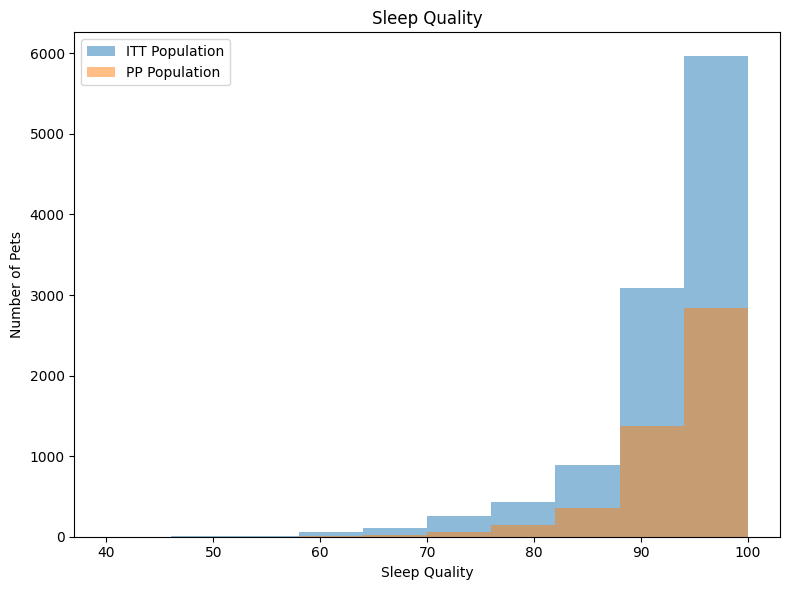

In [41]:
plot_sleep_quality_comparison(quality1, quality2, 'Sleep Quality', 'Sleep Quality', 'ITT Population', 'PP Population')

In [42]:
activity_columns = ['VAR_TD_1_Q5_2', 'VAR_TD_3_Q5_2', 'VAR_TD_5_Q5_2', 'VAR_TD_4_Q5_2', 'VAR_TD_12_Q5_2', 'VAR_TD_2_Q5_2']
columns_to_keep = activity_columns + ['PET_ID', 'wearables_itt', 'wearables_pp']
activity = final[columns_to_keep].copy()
activity.rename(columns=activity_map, inplace=True)

In [43]:
activity.head()

,resting,running,scratching,shaking,sleeping,walking,PET_ID,wearables_itt,wearables_pp
4,37250,199,101,24,43181,5426,3347,True,True
5,40163,88,67,16,40718,5333,3347,True,True
10,36173,43,101,11,46327,3702,3347,True,True
11,28838,30,91,9,54675,2723,3347,True,True
12,36816,96,52,15,42264,7044,3347,True,True


In [44]:
activity['running'] = activity['running'] / 60
activity['walking'] = activity['walking'] / 60
activity['resting'] = activity['resting'] / 3600
activity['sleeping'] = activity['sleeping'] / 3600

In [45]:
activity['scratching_percent'] = 100 * activity['scratching'] / 86400
activity['shaking_percent'] = 100 * activity['shaking'] / 86400
activity['running_percent'] = 100 * activity['running'] / 1440
activity['walking_percent'] = 100 * activity['walking'] / 1440
activity['resting_percent'] = 100 * activity['resting'] / 24
activity['sleeping_percent'] = 100 * activity['sleeping'] / 24

In [46]:
activity1 = activity[activity['wearables_itt'] == True].copy()

activity2 = activity[activity['wearables_pp'] == True].copy()

In [47]:
calculate_statistics(activity1, 'running')

,Mean,SD,Median,Q1,Q3,IQR
0,2.974552,3.852406,1.683333,0.833333,3.483333,2.65


In [48]:
calculate_statistics(activity2, 'running')

,Mean,SD,Median,Q1,Q3,IQR
0,3.046523,4.021673,1.633333,0.85,3.5,2.65


In [49]:
perform_tests(activity1, activity2, 'running')

U-Statistic (Mann-Whitney U test): 25841218.5
P-Value (Mann-Whitney U test): 0.7136074950191555
P-Value (Permutation test): 0.28


(0.7136074950191555, 0.28)

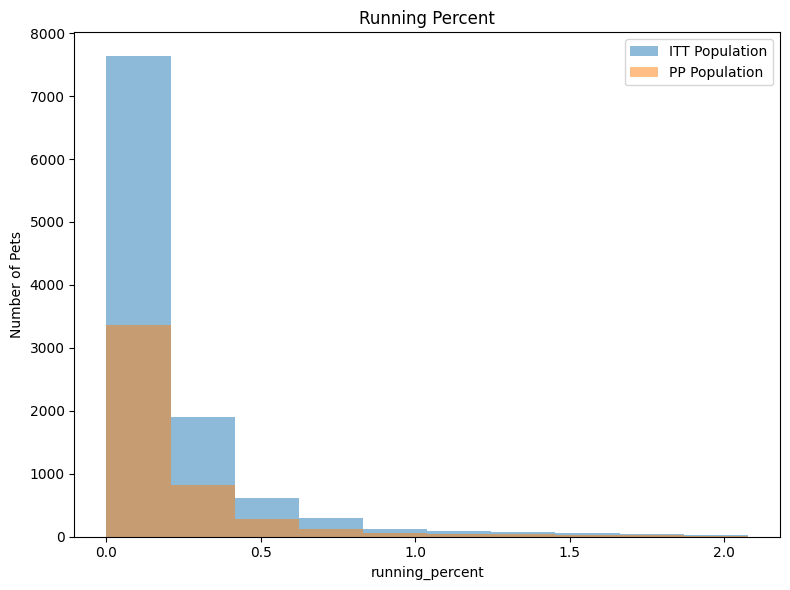

In [50]:
plot_sleep_quality_comparison(activity1, activity2, 'running_percent', 'Running Percent', 'ITT Population', 'PP Population')

In [51]:
calculate_statistics(activity1, 'walking')

,Mean,SD,Median,Q1,Q3,IQR
0,81.388496,37.015384,74.941667,54.1875,102.929167,48.741667


In [52]:
calculate_statistics(activity2, 'walking')

,Mean,SD,Median,Q1,Q3,IQR
0,79.495346,36.311636,73.391667,53.15,99.233333,46.083333


In [53]:
perform_tests(activity1, activity2, 'walking')

U-Statistic (Mann-Whitney U test): 26723893.0
P-Value (Mann-Whitney U test): 0.0024493457832202997
P-Value (Permutation test): 0.005


(0.0024493457832202997, 0.005)

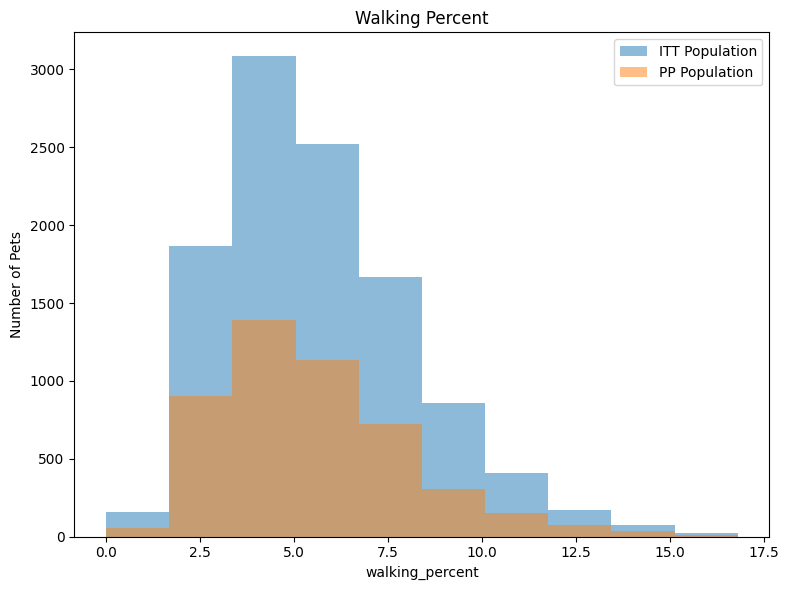

In [54]:
plot_sleep_quality_comparison(activity1, activity2, 'walking_percent', 'Walking Percent', 'ITT Population', 'PP Population')

In [55]:
calculate_statistics(activity1, 'scratching')

,Mean,SD,Median,Q1,Q3,IQR
0,60.025291,80.020547,34.0,17.0,67.0,50.0


In [56]:
calculate_statistics(activity2, 'scratching')

,Mean,SD,Median,Q1,Q3,IQR
0,54.541562,64.369061,33.0,16.0,66.0,50.0


In [57]:
perform_tests(activity1, activity2, 'scratching')

U-Statistic (Mann-Whitney U test): 26311710.0
P-Value (Mann-Whitney U test): 0.14886213136801021
P-Value (Permutation test): 0.0


(0.14886213136801021, 0.0)

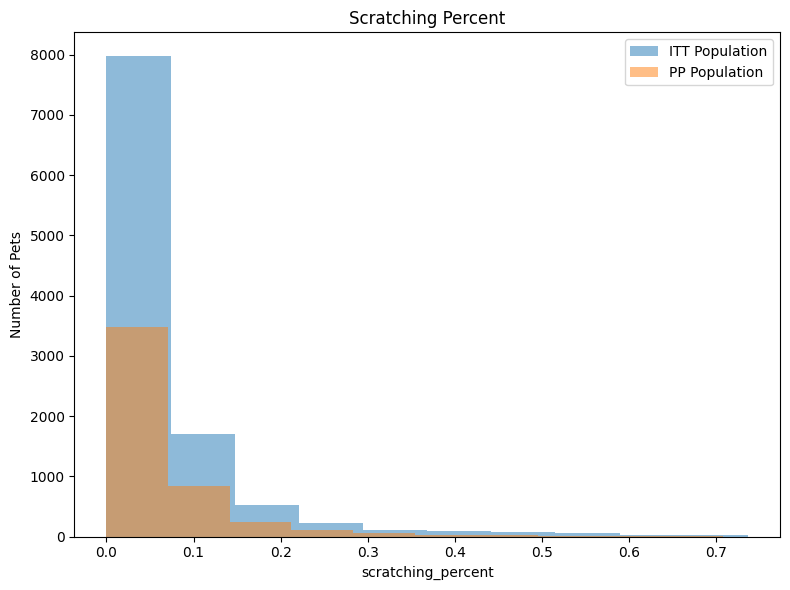

In [58]:
plot_sleep_quality_comparison(activity1, activity2, 'scratching_percent', 'Scratching Percent', 'ITT Population', 'PP Population')

In [59]:
calculate_statistics(activity1, 'shaking')

,Mean,SD,Median,Q1,Q3,IQR
0,29.019568,17.624151,25.0,17.0,37.0,20.0


In [60]:
calculate_statistics(activity2, 'shaking')

,Mean,SD,Median,Q1,Q3,IQR
0,28.791771,17.4167,25.0,17.0,36.0,19.0


In [61]:
perform_tests(activity1, activity2, 'shaking')

U-Statistic (Mann-Whitney U test): 26011183.0
P-Value (Mann-Whitney U test): 0.7740496005651171
P-Value (Permutation test): 0.476


(0.7740496005651171, 0.476)

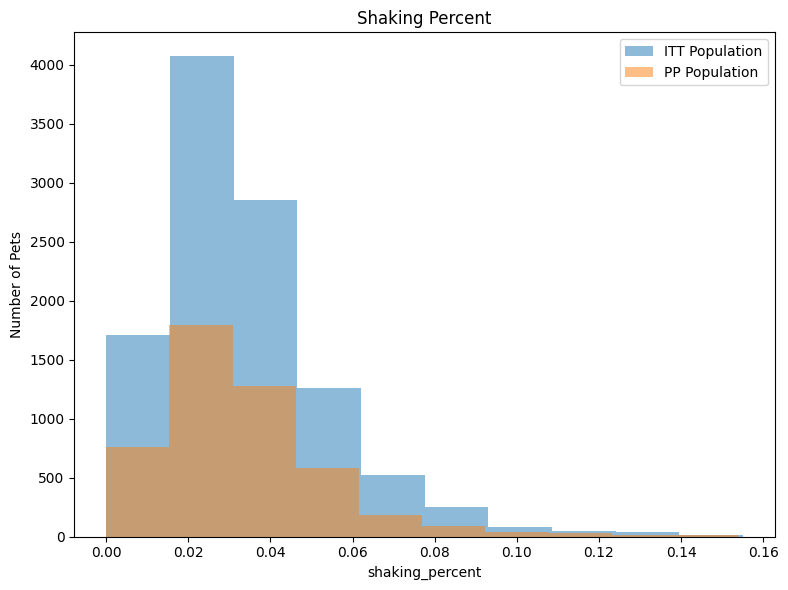

In [62]:
plot_sleep_quality_comparison(activity1, activity2, 'shaking_percent', 'Shaking Percent', 'ITT Population', 'PP Population')

In [63]:
calculate_statistics(activity1, 'resting')

,Mean,SD,Median,Q1,Q3,IQR
0,8.87922,1.626156,8.891944,7.819514,9.951806,2.132292


In [64]:
calculate_statistics(activity2, 'resting')

,Mean,SD,Median,Q1,Q3,IQR
0,8.716382,1.573745,8.786528,7.637222,9.820625,2.183403


In [65]:
perform_tests(activity1, activity2, 'resting')

U-Statistic (Mann-Whitney U test): 27358675.5
P-Value (Mann-Whitney U test): 4.445242961149255e-08
P-Value (Permutation test): 0.0


(4.445242961149255e-08, 0.0)

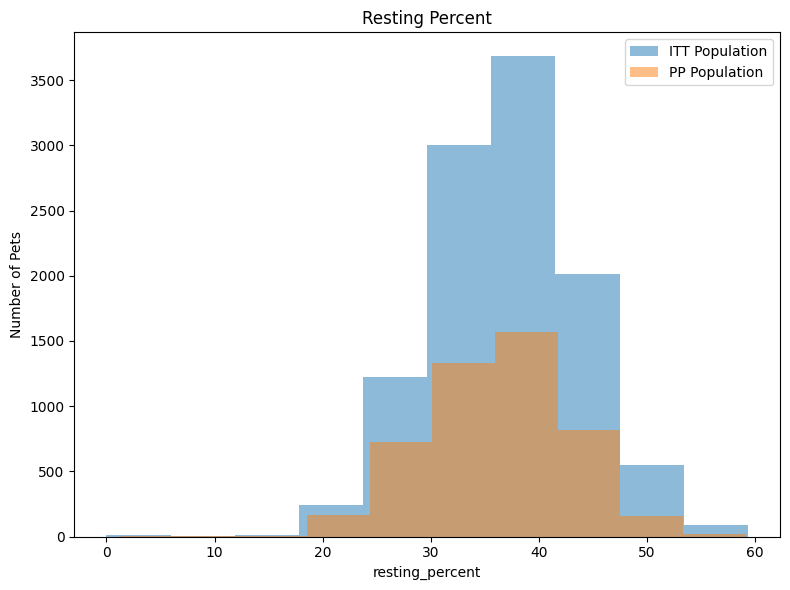

In [66]:
plot_sleep_quality_comparison(activity1, activity2, 'resting_percent', 'Resting Percent', 'ITT Population', 'PP Population')

In [67]:
calculate_statistics(activity1, 'sleeping')

,Mean,SD,Median,Q1,Q3,IQR
0,13.356924,1.964015,13.325417,12.043542,14.662222,2.618681


In [68]:
calculate_statistics(activity2, 'sleeping')

,Mean,SD,Median,Q1,Q3,IQR
0,13.562237,1.885569,13.529722,12.290833,14.893889,2.603056


In [69]:
perform_tests(activity1, activity2, 'sleeping')

U-Statistic (Mann-Whitney U test): 24307711.5
P-Value (Mann-Whitney U test): 3.6577935597662084e-10
P-Value (Permutation test): 0.0


(3.6577935597662084e-10, 0.0)

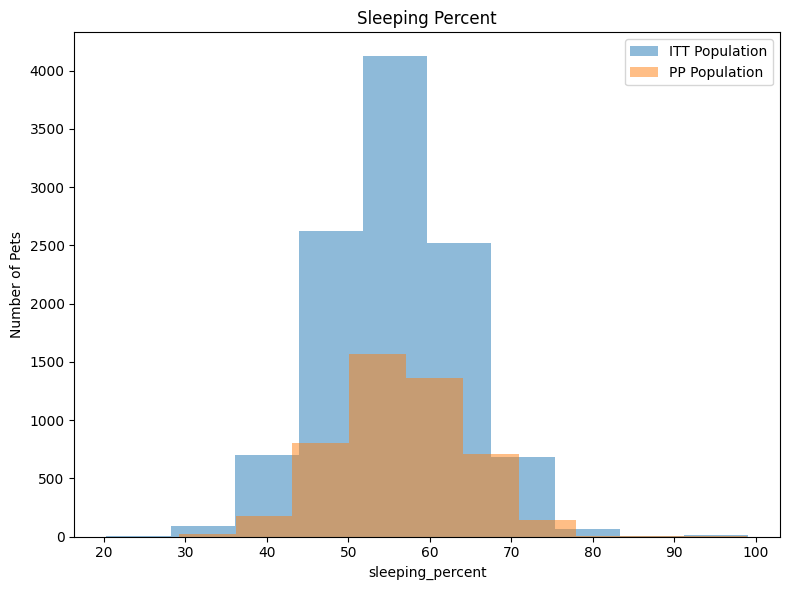

In [70]:
plot_sleep_quality_comparison(activity1, activity2, 'sleeping_percent', 'Sleeping Percent', 'ITT Population', 'PP Population')

In [71]:
stuck_columns = ['VAR1_TD_8_Q5_2', 'VAR2_TD_8_Q5_2', 'VAR3_TD_8_Q5_2', 'VAR4_TD_8_Q5_2']
stuck_columns_to_keep = stuck_columns + ['PET_ID', 'wearables_itt', 'wearables_pp']
stuck = final[stuck_columns_to_keep].copy()
stuck.rename(columns=activity_map, inplace=True)

In [72]:
stuck[['Stuck AccelX', 'Stuck AccelY', 'Stuck AccelZ', 'Stuck AccelM']] = stuck[['Stuck AccelX', 'Stuck AccelY', 'Stuck AccelZ', 'Stuck AccelM']] / 60

In [73]:
stuck['Stuck_AccelX_percent'] = 100 * stuck['Stuck AccelX'] / 1440
stuck['Stuck_AccelY_percent'] = 100 * stuck['Stuck AccelY'] / 1440
stuck['Stuck_AccelZ_percent'] = 100 * stuck['Stuck AccelZ'] / 1440
stuck['Stuck_AccelM_percent'] = 100 * stuck['Stuck AccelM'] / 1440

In [74]:
stuck.head()

,Stuck AccelX,Stuck AccelY,Stuck AccelZ,Stuck AccelM,PET_ID,wearables_itt,wearables_pp,Stuck_AccelX_percent,Stuck_AccelY_percent,Stuck_AccelZ_percent,Stuck_AccelM_percent
4,0.0,0.0,2.016667,0.0,3347,True,True,0.0,0.0,0.140046,0.0
5,0.0,0.0,0.000000,0.0,3347,True,True,0.0,0.0,0.000000,0.0
10,0.0,0.0,0.000000,0.0,3347,True,True,0.0,0.0,0.000000,0.0
11,0.0,0.0,0.000000,0.0,3347,True,True,0.0,0.0,0.000000,0.0
12,0.0,0.0,0.000000,0.0,3347,True,True,0.0,0.0,0.000000,0.0


In [75]:
stuck1 = stuck[stuck['wearables_itt'] == True].copy()

stuck2 = stuck[stuck['wearables_pp'] == True].copy()

In [76]:
calculate_statistics(stuck1, 'Stuck AccelZ')

,Mean,SD,Median,Q1,Q3,IQR
0,0.275857,2.99955,0.0,0.0,0.0,0.0


In [77]:
calculate_statistics(stuck2, 'Stuck AccelZ')

,Mean,SD,Median,Q1,Q3,IQR
0,0.126921,1.465222,0.0,0.0,0.0,0.0


In [78]:
perform_tests(stuck1, stuck2, 'Stuck AccelZ')

U-Statistic (Mann-Whitney U test): 26593783.5
P-Value (Mann-Whitney U test): 8.088700866638594e-11
P-Value (Permutation test): 0.0


(8.088700866638594e-11, 0.0)

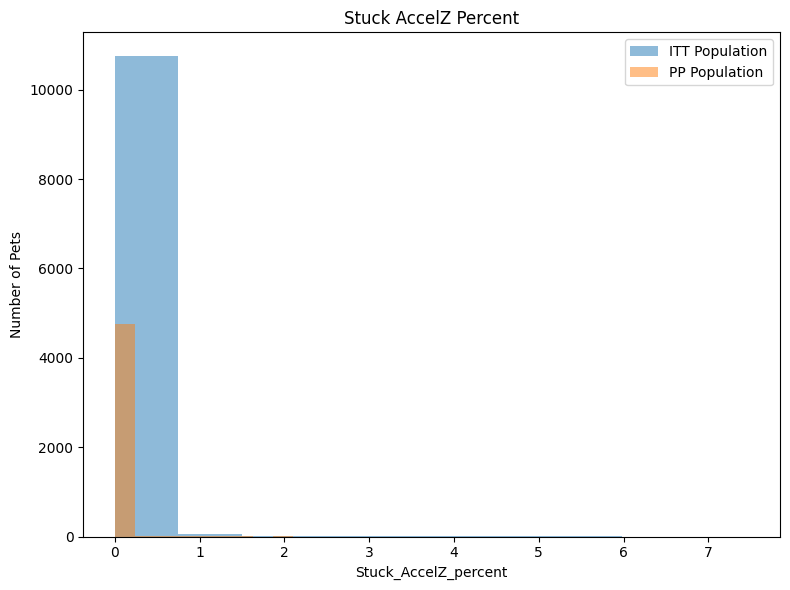

In [79]:
plot_sleep_quality_comparison(stuck1, stuck2, 'Stuck_AccelZ_percent', 'Stuck AccelZ Percent', 'ITT Population', 'PP Population')

# Correlation Matrix of the Percentage of Time Spent

In [80]:
# Keep columns from the standard behavior list
columns_to_keep = ['VAR_TD_1_Q5_2', 'VAR_TD_3_Q5_2', 'VAR_TD_5_Q5_2', 'VAR_TD_4_Q5_2', 
                   'VAR_TD_12_Q5_2', 'VAR_TD_2_Q5_2', 'VAR_IDX_11_Q5_2', 'wearables_itt', 'wearables_pp']

In [81]:
# Create new dataset based on the selected columns
correlation_data = final[columns_to_keep].copy()
correlation_data[['VAR_TD_1_Q5_2', 'VAR_TD_3_Q5_2', 'VAR_TD_5_Q5_2', 'VAR_TD_4_Q5_2', 'VAR_TD_12_Q5_2', 
                  'VAR_TD_2_Q5_2']] = correlation_data[['VAR_TD_1_Q5_2', 'VAR_TD_3_Q5_2', 'VAR_TD_5_Q5_2', 'VAR_TD_4_Q5_2', 'VAR_TD_12_Q5_2', 'VAR_TD_2_Q5_2']] / 86400

In [82]:
# Rename the columns by 'activity_map' in the data_process
correlation_data.rename(columns=activity_map, inplace=True)

In [83]:
corr_data1 = correlation_data[correlation_data['wearables_itt'] == True].copy()
corr_data2 = correlation_data[correlation_data['wearables_pp'] == True].copy()

In [84]:
corr_data1.drop(['wearables_itt', 'wearables_pp'], axis=1, inplace=True)
corr_data2.drop(['wearables_itt', 'wearables_pp'], axis=1, inplace=True)

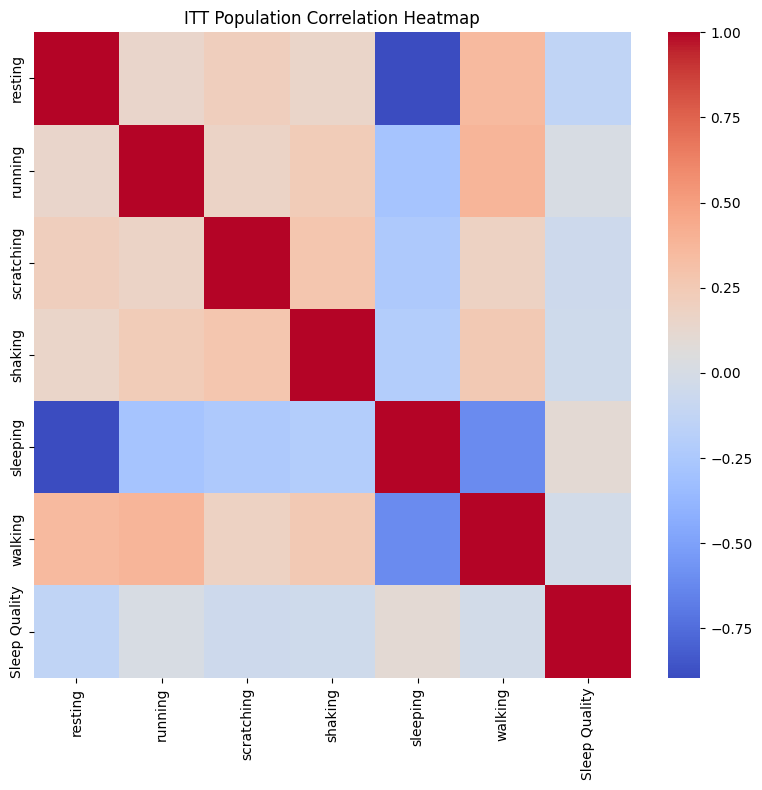

In [85]:
# Create ITT correlation matrix

new_corr_matrix = corr_data1.corr()

plt.figure(figsize=(8, 8))

sns.heatmap(new_corr_matrix, cmap='coolwarm')

plt.title('ITT Population Correlation Heatmap')

plt.tight_layout()
plt.savefig('heatmap.pdf')

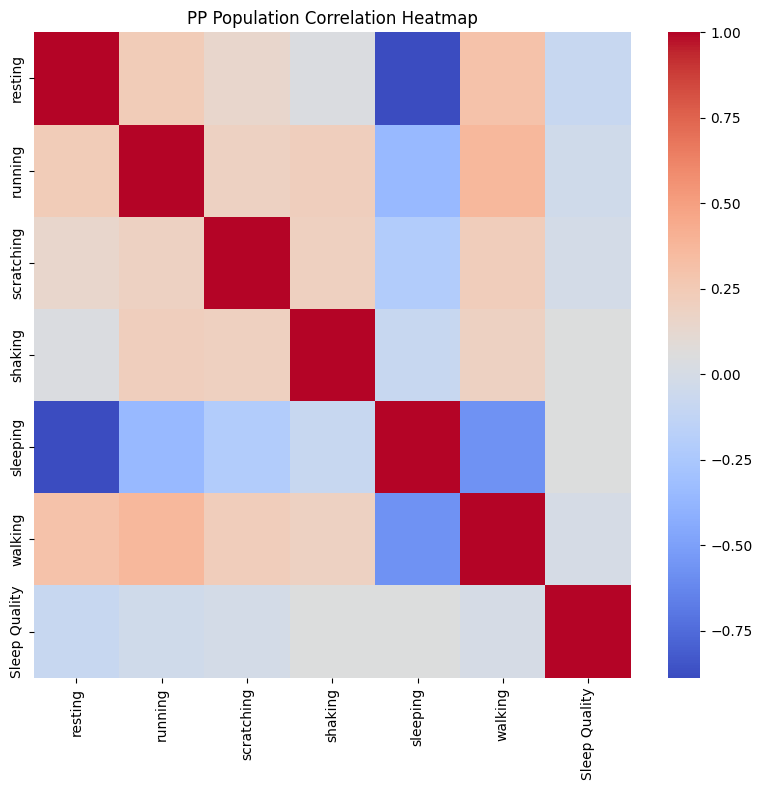

In [86]:
# Create PP correlation matrix
new_corr_matrix = corr_data2.corr()

plt.figure(figsize=(8, 8))

sns.heatmap(new_corr_matrix, cmap='coolwarm')

plt.title('PP Population Correlation Heatmap')

plt.tight_layout()
plt.savefig('heatmap.pdf')